# Rank Based Analysis: (535, 536)
Outlier detection method proposed by Barbara. It is based on these steps: 

1. Order the set by rank on occurrences
2. Extract the subset of values that happens `SENSITIVITY` of the time
3. any value outside [ min(subset), max(subset) ] is an outlier 

Sensitivity is set to:

In [1]:
SENSITIVITY = 0.99

In [2]:
from src import *
from src.models.AlmaClasses import *

from pandas import Series
from pandas import DataFrame
from matplotlib import pyplot
import numpy as np

palette = PaletteFileDB(
    filename='../data/processed/colors-almaAntenna.pkl', 
    colorFunction=paintedForAlmaAntennas )

db = DelaysFileDB( 
    caseName="CaseRadioSetup", 
    path= '../' + config.FILEPATH_DB + "/delays")  

## Pair to study
As a first example we will study this pair:

In [3]:
#(a,b) = (510, 511)
(a, b) = (382, 384)
# (a, b) = (528, 533)

In [4]:
 "C_%s: %s" % (a, palette.getColors()[a])

'C_382: [CONTROL/${ANT}/FrontEnd - void FrontEndImpl::mixerDefluxInternal(ReceiverBandMod::ReceiverBand)] Begin Demagnetizing band #${N}'

In [5]:
"C_%s: %s" % (b, palette.getColors()[b])

'C_384: [CONTROL/${ANT}/FrontEnd - void FrontEndImpl::mixerDefluxInternal(ReceiverBandMod::ReceiverBand)] Begin Defluxing band #${N}'

`pandas.Series` is used below, it allows handy serie manipulation.

In [6]:
delays = Series(db.getDelays(a,b))

In [7]:
delays.describe()

count     566.000000
mean      790.270318
std       990.613624
min         0.000000
25%         0.000000
50%       227.000000
75%      1782.750000
max      3419.000000
dtype: float64

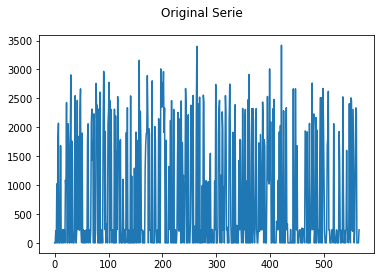

In [8]:
fig = pyplot.figure()
fig.suptitle('Original Serie')
pyplot.plot(delays)
pyplot.show()

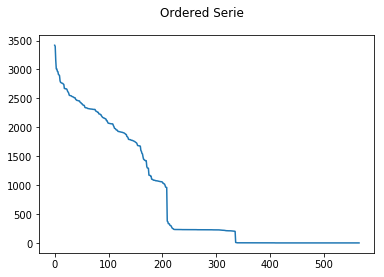

In [9]:
fig = pyplot.figure()
fig.suptitle('Ordered Serie')
# pyplot.yscale('log')
pyplot.plot(sorted(delays, reverse=True))
pyplot.show()

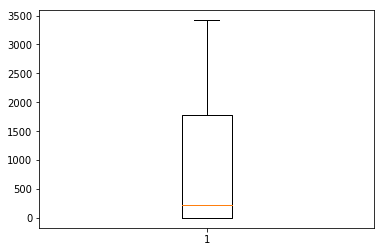

In [10]:
# Simple boxplot
pyplot.boxplot( delays )
pyplot.show()

In [11]:
# DataFrame(delays).boxplot()

## Applying Method
Extracting the rank based on # of occurrences, and make a plot

In [12]:
value_counts = delays.value_counts()

print "Value=%s happens %s times" % (value_counts.index[0], value_counts.values[0])
print "Value=%s happens %s times" % (value_counts.index[1], value_counts.values[1])
print "Value=%s happens %s times" % (value_counts.index[10], value_counts.values[10])


value_counts

Value=0 happens 157 times
Value=1 happens 61 times
Value=210 happens 4 times


0       157
1        61
227      17
230      15
229      13
228      12
231      10
2         9
226       8
225       5
210       4
2665      3
221       3
232       3
209       3
2060      3
3010      2
2316      2
2338      2
2160      2
2512      2
2117      2
2309      2
2310      2
2671      2
1076      2
203       2
205       2
212       2
219       2
       ... 
2390      1
2530      1
2533      1
199       1
959       1
1711      1
2094      1
1684      1
1682      1
1681      1
1680      1
1678      1
1673      1
1050      1
2258      1
2650      1
1600      1
2543      1
2622      1
1788      1
2609      1
1584      1
2592      1
1549      1
1540      1
2556      1
2550      1
2547      1
2546      1
2406      1
Length: 237, dtype: int64

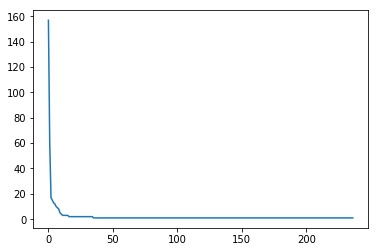

In [13]:
pyplot.plot(value_counts.values)
pyplot.show()

The rank obtained in `value_counts` shows that the evident `outlier=214` happens only 1 time, 41 happens 2 times. Let's see the tail of the ordered original delays: (yes, they are here!)

In [14]:
sorted(delays)[-10:]

[2894, 2906, 2914, 2963, 2968, 3010, 3010, 3159, 3400, 3419]

Now, obtain the subset of values that, combined, appears `SENSITIVE` amount of times

In [15]:
# Cumulative sum on value_counts.
cumsum = value_counts.cumsum()

In [16]:
total = cumsum[-1:].values[0]
total

566

In [17]:
percentageCumsum = cumsum / total

In [18]:
# Note that this method is simpler, but the very explicit results with percentageCumsum is shown for clarity
#typicalValues = cumsum[ cumsum <= SENSITIVITY * total ]

typicalValues = percentageCumsum[ percentageCumsum <= SENSITIVITY]
typicalValues

0       0.277385
1       0.385159
227     0.415194
230     0.441696
229     0.464664
228     0.485866
231     0.503534
2       0.519435
226     0.533569
225     0.542403
210     0.549470
2665    0.554770
221     0.560071
232     0.565371
209     0.570671
2060    0.575972
3010    0.579505
2316    0.583039
2338    0.586572
2160    0.590106
2512    0.593640
2117    0.597173
2309    0.600707
2310    0.604240
2671    0.607774
1076    0.611307
203     0.614841
205     0.618375
212     0.621908
219     0.625442
          ...   
376     0.938163
2423    0.939929
368     0.941696
2408    0.943463
1018    0.945230
3419    0.946996
2390    0.948763
2530    0.950530
2533    0.952297
199     0.954064
959     0.955830
1711    0.957597
2094    0.959364
1684    0.961131
1682    0.962898
1681    0.964664
1680    0.966431
1678    0.968198
1673    0.969965
1050    0.971731
2258    0.973498
2650    0.975265
1600    0.977032
2543    0.978799
2622    0.980565
1788    0.982332
2609    0.984099
1584    0.9858

In [19]:
minVal, maxVal = min(typicalValues.index), max(typicalValues.index)
minVal, maxVal

(0, 3419)

# Testing the method
A graph with the "typical" part (minVal < t < maxVal) is shown, with some stats metrics.

In [20]:
typicalDelays = delays[ minVal <= delays ][ delays <= maxVal ]
typicalDelays.describe()

count     566.000000
mean      790.270318
std       990.613624
min         0.000000
25%         0.000000
50%       227.000000
75%      1782.750000
max      3419.000000
dtype: float64

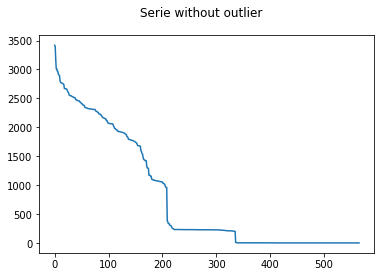

In [21]:
fig = pyplot.figure()
fig.suptitle('Serie without outlier')
pyplot.plot(sorted(typicalDelays, reverse=True))
pyplot.show()

Found Outliers:

In [22]:
"%s of %s (%.3f%%)" % ( len(delays) - len(typicalDelays), len(delays), 100*(1.0*len(delays) - len(typicalDelays))/len(delays) )

'0 of 566 (0.000%)'

In [23]:
delays[ delays < minVal ].values

array([], dtype=int64)

In [24]:
delays[ maxVal < delays ].sort_values().values

array([], dtype=int64)

In [25]:
# All the above in one function
def minmax_rank_based( values, sensitivity ):
    value_counts = Series(values).value_counts()
    cumsum = value_counts.cumsum()
    typicalValues = cumsum[ cumsum <= sensitivity * value_counts.sum() ]
    return min(typicalValues.index), max(typicalValues.index)

In [27]:
minmax_rank_based( db.getDelays(a,b), SENSITIVITY )

(0, 3419)

## Discussion
The minmax_rank_based function uses parameter S, the sensitivity. Playing with S from 0.80 to 0.99 means removing outliers from 1% to 20% of the data, and can give insights on how stable the AB-serie is. 

In [35]:
changingSensitivity=[ minmax_rank_based( db.getDelays(a,b), 0.5 + S/100.0 ) for S in range(1, 50) ]

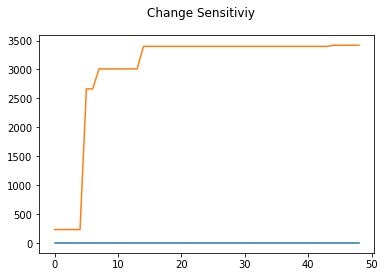

In [36]:
fig = pyplot.figure()
fig.suptitle('Change Sensitiviy')
pyplot.plot(changingSensitivity)
pyplot.show()

In [32]:
changingSensitivity

[(0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3400),
 (0, 3419),
 (0, 3419),
 (0, 3419),
 (0, 3419),
 (0, 3419)]